This notebook walks through an example of how to use the Aryn Partitioning Service with OpenAI's gpt-40-mini model to transform process flow diagrams (PFDs) into a DAG encoded in JSON.

We first use the Aryn SDK to pull out an image of the PFD from a page. We then send that diagram to OpenAI's gpt model and ask it to transform the contents of that flow into a DAG expressed as nodes and edges in a JSON.

You will need an Aryn API key and an Open AI API key to run this notebook. You can obtain an Aryn API key [here](https://www.aryn.ai/get-started ) and an OpenAI API key [here](https://platform.openai.com/api-keys).

In [ ]:
#Install Aryn SDK
!pip install aryn-sdk

#Install Poppler utils so the PDF can be displayed
!apt-get install poppler-utils

#Install OpenAI SDK
!pip install openai

#Install pydantic
!pip install pydantic

In [71]:
# Import necessary functions
import aryn_sdk
from aryn_sdk.partition import partition_file, draw_with_boxes, convert_image_element, table_elem_to_dataframe
import json
import pdf2image
from openai import OpenAI
from pydantic import BaseModel
from openai.lib._parsing import type_to_response_format_param as pydantic_to_response_format
from google.colab import userdata

In [72]:
# Set your secrets in the colab notebook. Navigate to the left pane
# and choose the key option to set your keys. Make sure to enable Notebook access

# Visit https://www.aryn.ai/get-started to get a key.
aryn_api_key = userdata.get('aryn_api_key')

# Visit https://platform.openai.com/api-keys to get a key.
openai_api_key = userdata.get('openai_api_key')

In [73]:
# get files from Aryn's public S3 bucket.
#![ -f PFD2.pdf ] || wget https://aryn-public.s3.amazonaws.com/partitioner-blog-data/PFD2.pdf
#![ -f PFD_2017.pdf ] || wget https://aryn-public.s3.amazonaws.com/partitioner-blog-data/PFD_2017.pdf
#![ -f PFD_2018.pdf ] || wget https://aryn-public.s3.amazonaws.com/partitioner-blog-data/PFD_2018.pdf

In [ ]:
# open the file
file_name = 'PFD2.pdf'

# show the pdf
pdf2image.convert_from_path(file_name)[0]

In [ ]:
# Open the file.
file = open(file_name, 'rb')

## Make a call to the partitioning service to break down the file into its constituent
## components: images, tables, and captions. The documents elements are returned in a Python dict.
document_dict = partition_file(file, aryn_api_key, extract_images=True, extract_table_structure=True, use_ocr=True, threshold=0.20)

# show the pdf with bounding boxes of the elements superimposed.
draw_with_boxes(file_name, document_dict)[0]

In [ ]:
## Walk over the table elements in the returned document dict and show the first one
tables = [e for e in document_dict['elements'] if e['type'] == 'table']

## Convert the table to a pandas dataframe and display it.
table_df = table_elem_to_dataframe(tables[0])
display(table_df)
print("\n")

## Walk over the image elements in the returned document dict and show the first one
images = [e for e in document_dict['elements'] if e['type'] == 'Image']
images[0]

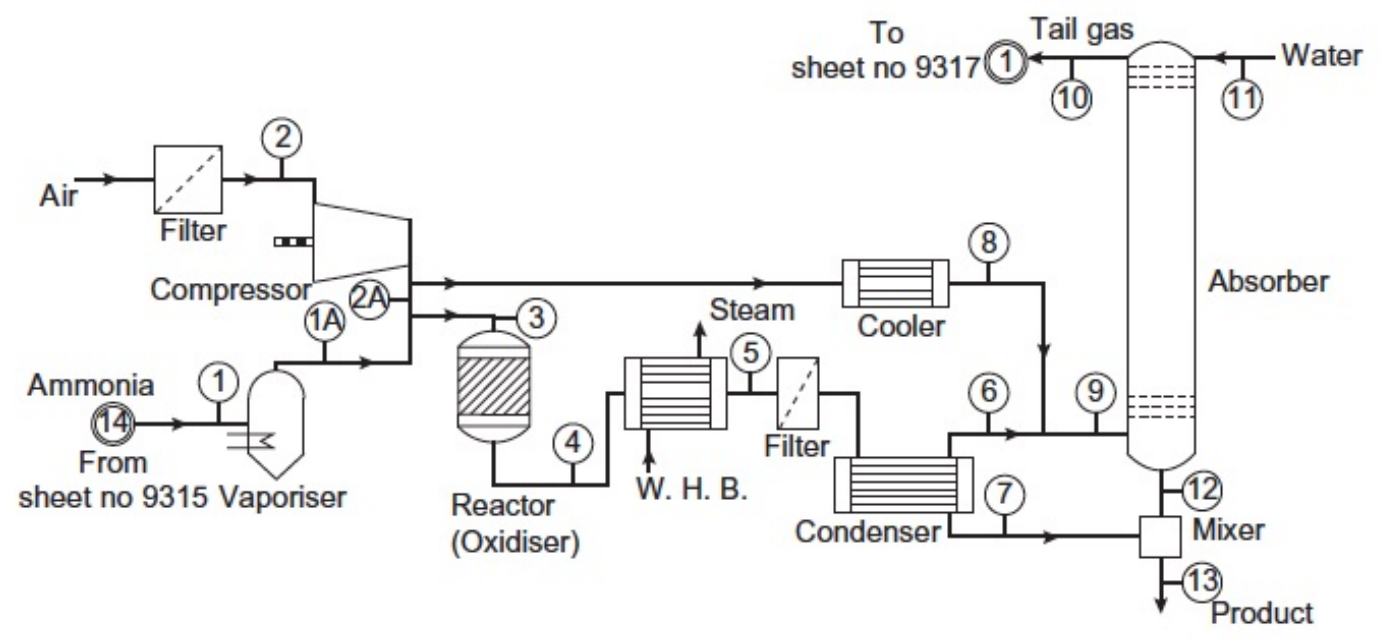

In [77]:
## Let's convert image to PIL to see it more closely.
pil_img = convert_image_element(images[0], format='PIL')
display(pil_img)

In [78]:
# Setup Pydantic models for a labeled DAG (directed acyclic graph) to form a response_format for gpt-4o
class node(BaseModel):
    label: str
    description: str

class edge(BaseModel):
    source: str
    target: str
    description: str

class diagram_DAG(BaseModel):
    nodes: list[node]
    edges: list[edge]

response_format = pydantic_to_response_format(diagram_DAG)

In [80]:
# convert image to base64 encoded JPEG for OpenAI to process it.
jpeg_img = convert_image_element(images[0], format='JPEG', b64encode=True)

# Execute a completion request to gpt-4o and print the response.
openai_client = OpenAI(api_key=openai_api_key)

response = openai_client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text",
         "text": """Transform the following PFD (process flow) diagram into a DAG and return it in JSON.
                    Ensure each node has a unique label. Ignore the labeled circles.
                 """},
        {
          "type": "image_url",
          "image_url": {"url": f"data:image/jpeg;base64,{jpeg_img}", "detail": "high"},
        },
      ],
    }
  ],
  # Ask openAI to respond back with
  response_format = response_format,
  max_tokens=1000,
)

# The response from gpt-4o will be a JSON string
DAG_json = response.choices[0].message.content
# print("Returned JSON:")
# print(DAG_json)
# print("\n")

# Load the JSON response from gpt-4o into a dict and print it
DAG_dict = json.loads(DAG_json)
print("Python DAG:")
print("Nodes:")
for n in DAG_dict['nodes']:
  print(f"  \"{n['label']}\": \"{n['description']}\"")
print("Edges:")
for e in DAG_dict['edges']:
  print(f"  \"{e['source']}\" -> \"{e['target']}\": \"{e['description']}\"")
print("\n")

Python DAG:
Nodes:
  "Node_1": "Air"
  "Node_2": "Filter"
  "Node_3": "Compressor"
  "Node_4": "Ammonia"
  "Node_5": "Reactor (Oxidiser)"
  "Node_6": "W.H.B."
  "Node_7": "Steam"
  "Node_8": "Cooler"
  "Node_9": "Filter"
  "Node_10": "Condenser"
  "Node_11": "Absorber"
  "Node_12": "Mixer"
  "Node_13": "Product"
  "Node_14": "Tail gas"
  "Node_15": "Water"
Edges:
  "Node_1" -> "Node_2": "Air goes to Filter"
  "Node_2" -> "Node_3": "Filtered air to Compressor"
  "Node_4" -> "Node_5": "Ammonia to Reactor"
  "Node_3" -> "Node_5": "Compressed air to Reactor"
  "Node_5" -> "Node_6": "Reactor output to W.H.B."
  "Node_6" -> "Node_7": "Heat exchange to Steam"
  "Node_7" -> "Node_8": "Steam to Cooler"
  "Node_8" -> "Node_9": "Cooler output to Filter"
  "Node_9" -> "Node_10": "Filter output to Condenser"
  "Node_10" -> "Node_11": "Condenser output to Absorber"
  "Node_11" -> "Node_12": "Output to Mixer"
  "Node_12" -> "Node_13": "Mixing to Product"
  "Node_13" -> "Node_14": "Output to Tail gas"

In [81]:
# This function combines all of the above mentioned steps

def convert_pfd_to_dag(pfd_fn: str, openai_client: OpenAI) -> dict:

  # show the first page of the PDF
  # display(pdf2image.convert_from_path(pfd_fn)[0])

  # Open the file.
  pfd_file = open(pfd_fn, 'rb')

  ## Make a call to the partitioning service to break down the filex into their constituent
  ## components: images, tables, and captions.
  pfd_dict = partition_file(pfd_file, aryn_api_key, extract_images=True, extract_table_structure=True, use_ocr=True, threshold=0.20)

  ## Walk over the image elements in the returned document dict and show the first one
  pfd_images = [e for e in pfd_dict['elements'] if e['type'] == 'Image']

  print("Converting this PFD diagram: ")
  ## Let's convert image to PIL to see it more closely.
  pfd_pil_img = convert_image_element(pfd_images[0], format='PIL')
  display(pfd_pil_img)

  # convert image to base64 encoded JPEG for gpt-4o-mini to process it.
  pfd_jpeg = convert_image_element(pfd_images[0], format='JPEG', b64encode=True)

  print("Calling gpt-4o: ")
  response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text",
           "text": """Transform the following PFD (process flow) diagram into a DAG and return it in JSON.
                      Ensure each node has a unique label. """},
          {"type": "image_url",
           "image_url": {"url": f"data:image/jpeg;base64,{pfd_jpeg}", "detail": "high"},},
        ],
      }
    ],

    # Ask openAI to respond back with
    response_format = response_format,
    max_tokens=5000,
  )

  # The response from gpt-4o will be a JSON string
  pfd_json = response.choices[0].message.content
  # print("Returned JSON:")
  # print(pfd_json)
  # print("\n")

  # Load the JSON response from gpt-4o into a dict and print it
  pfd_DAG = json.loads(pfd_json)
  print("Python DAG:")
  print("Nodes:")
  for n in pfd_DAG['nodes']:
    print(f"  \"{n['label']}\": \"{n['description']}\"")
  print("Edges:")
  for e in pfd_DAG['edges']:
    print(f"  \"{e['source']}\" -> \"{e['target']}\": \"{e['description']}\"")
  print("\n")

  return pfd_DAG

In [ ]:
convert_pfd_to_dag('PFD_2017.pdf', openai_client)
convert_pfd_to_dag('PFD_2018.pdf', openai_client)